In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from radical.entk import Profiler
import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp

%matplotlib

/Users/JumanaDakka/git/old_htbac_experiments/ve_htbac/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


Using matplotlib backend: TkAgg


In [2]:
# Entire list of pipeline values for which profiles are available

pipelines_list = [8, 16, 32, 128]

In [3]:
# Generate task uids

def get_task_uids(num_pipelines):
    
    num_tasks = num_pipelines*7*1
    task_uids = []
    for t in range(num_tasks):
        task_uids.append('radical.entk.task.%04d'%t)

    return task_uids

In [4]:
# Get information from all the entk profiles

def get_entk_info(pipelines):
    
    p = Profiler(src = './replicas-{0}-trial-1/'.format(pipelines))
    
    task_uids = get_task_uids(pipelines)
    
    entk_dur = p.duration(task_uids, states=['SCHEDULING','DONE'])
    
    # Time taken in appmanager to rreq function call
    entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
    
    # Time taken to tear down appmanager
    entk_core_2 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
    
    # Time taken to create resource manager obj
    entk_core_3 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
    
    # Time taken to create and submit resource reservation
    entk_core_4 = p.duration('radical.entk.resource_manager.0000', events = ['creating rreq', 'rreq submitted'])
    
    # Time taken to deallocate resource reservation
    entk_core_5 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
    
    entk_core_dur = entk_core_1 + entk_core_2 + entk_core_3 
    
    #entk_total_dur = entk_dur_1 + entk_dur_2 + entk_core_dur
    
    return entk_dur

In [5]:
# Get information from all the rp profile files and json file
# returns 0,0 if no rp files are found

def get_rp_info(pipelines):

    try:
        json_files = glob.glob('./replicas-{0}-trial-1/*.json'.format(pipelines))
        print json_files
        json_file = json_files[0]
        json      = ru.read_json(json_file)
        sid       = os.path.basename(json_file)[:-5]

        session = ra.Session(sid, 'radical.pilot', src='replicas-{0}-trial-1/'.format(pipelines))
        units = session.filter(etype='unit', inplace=False)
    
        exec_dur = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
        rp_dur = units.duration([rp.UMGR_SCHEDULING_PENDING, rp.DONE])
        data_dur = units.duration([rp.UMGR_STAGING_INPUT, rp.AGENT_STAGING_INPUT_PENDING]) + units.duration([rp.AGENT_STAGING_INPUT, rp.AGENT_SCHEDULING_PENDING]) + units.duration([rp.AGENT_STAGING_OUTPUT, rp.UMGR_STAGING_OUTPUT_PENDING]) + units.duration([rp.UMGR_STAGING_OUTPUT, rp.DONE])
        
        return exec_dur, rp_dur, data_dur
    except:
        return 0, 0


In [22]:
df = pd.DataFrame(columns=['EnTK overhead', 'RP overhead', 'Execution duration'])

for pipelines in pipelines_list:
       
    entk_dur = get_entk_info(pipelines)
    exec_dur, rp_dur, data_dur = get_rp_info(pipelines)
    
    print entk_dur, rp_dur, exec_dur, data_dur
    df.loc[pipelines] = [entk_dur - rp_dur, rp_dur - exec_dur, exec_dur]

['./replicas-8-trial-1/rp.session.two.vivek.017421.0001.json']
34541.5716 34539.1334999 34487.8205001 95.9489989281
['./replicas-16-trial-1/rp.session.two.vivek.017422.0000.json']
34823.7729003 34820.4647 34751.5615001 144.410502195
['./replicas-32-trial-1/rp.session.two.jdakka.017421.0000.json']
34602.0472996 34598.9305999 34517.8471999 303.5592978
['./replicas-128-trial-1/rp.session.two.jdakka.017422.0000.json']
35275.3031001 35269.2497001 35044.3116004 1074.47659755


In [17]:
%matplotlib inline

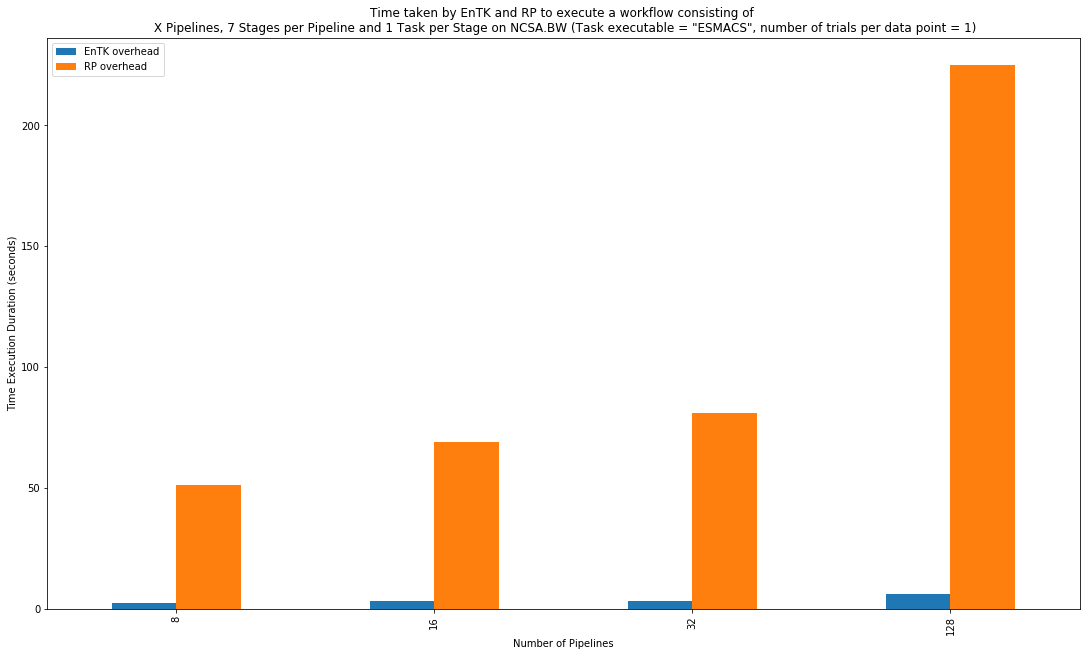

In [23]:
df = df.drop('Execution duration',axis=1)
ax1 = df.plot(kind='bar', title='Time taken by EnTK and RP to execute a workflow consisting of \n X Pipelines, 7 Stages per Pipeline and 1 Task per Stage on NCSA.BW (Task executable = "ESMACS", number of trials per data point = 1)')
ax1.set_xlabel('Number of Pipelines')
ax1.set_ylabel('Time Execution Duration (seconds)')

FONTSIZE=12
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.show()
#fig.savefig('namd_worload_devel.pdf', dpi=100)